This notebook reproduces some experiments based on the paper [*How do Language Models Bind Entities in Context?*](https://arxiv.org/pdf/2310.17191)

In [ ]:
%%capture
!pip install --upgrade transformer_lens

In [ ]:
!pip uninstall numpy pandas scipy -y
!pip install --upgrade numpy pandas scipy

Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4
Found existing installation: pandas 2.2.2
Uninstalling pandas-2.2.2:
  Successfully uninstalled pandas-2.2.2
Found existing installation: scipy 1.15.3
Uninstalling scipy-1.15.3:
  Successfully uninstalled scipy-1.15.3
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.9/16.9 MB 115.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 133.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.7/37.7 MB 19.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
transformer-lens 2.

In [1]:
import torch
import random
import numpy as np
import pandas as pd
from functools import partial
import torch.nn.functional as F
from transformer_lens import HookedTransformer
from transformers import AutoModelForCausalLM, AutoTokenizer

# **Prepare model**
To select a model, choose one from the following [link](https://github.com/jiahai-feng/binding-iclr/blob/main/coref/models.py). Bigger models have been found to present a greater binding performance, so it is recommended to choose the bigger that fits in your GPU.

# **Binding Taks**
Informally, binding consists in recognizing features of an object as bound to that object and not to others.

Formally, it consists of a set of entities $\mathcal{E}=\{e_i\}_{i=1}^n$ and attributes $\mathcal{A}=\{a_i\}_{i=1}^n$. A context with $n$ entity-attribute bindings is denoted as:

$$
  \pmb{c} = \text{ctxt}(e_1 \leftrightarrow a_1, \dots e_n \leftrightarrow a_n)
$$

In this notebook, we work with the *CAPITALS* task in which the $\mathcal{E}$ are names of people and $\mathcal{A}$ names of names of countries. For example, a context with $n=2$ could be:

$$
  \pmb{c} = \text{ctxt}(\text{Alice} \leftrightarrow \text{France}, \text{Bob} \leftrightarrow \text{Thailand})
$$

## **Prepare prompts**

In [ ]:
device = "cuda"
dtype = torch.float16
model_tag = "Qwen/Qwen2.5-1.5B"

torch.set_grad_enabled(False)
hf_model = AutoModelForCausalLM.from_pretrained(
    model_tag,
    low_cpu_mem_usage=True,
    torch_dtype=dtype
)
model = HookedTransformer.from_pretrained(
    model_tag,
    center_unembed=False,
    center_writing_weights=False,
    fold_ln=False,
    refactor_factored_attn_matrices=False,
    fold_value_biases=False,
    device=device,
    n_devices=1,
    hf_model=hf_model,
    dtype=dtype
)
model.model_tag = model_tag
model.eval()
print(hf_model)

Fetching 8 files:   0%|          | 0/8 [00:00<?, ?it/s]

model-00001-of-00008.safetensors:   0%|          | 0.00/3.89G [00:00<?, ?B/s]

model-00003-of-00008.safetensors:   0%|          | 0.00/4.00G [00:00<?, ?B/s]

model-00005-of-00008.safetensors:   0%|          | 0.00/3.98G [00:00<?, ?B/s]

model-00002-of-00008.safetensors:   0%|          | 0.00/4.00G [00:00<?, ?B/s]

model-00004-of-00008.safetensors:   0%|          | 0.00/4.00G [00:00<?, ?B/s]

model-00008-of-00008.safetensors:   0%|          | 0.00/1.70G [00:00<?, ?B/s]

model-00007-of-00008.safetensors:   0%|          | 0.00/4.00G [00:00<?, ?B/s]

model-00006-of-00008.safetensors:   0%|          | 0.00/4.00G [00:00<?, ?B/s]

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_tag)
df = pd.read_csv("country-list.csv")
country_capital_pairs = [(r.country, r.capital) for r in df.itertuples()]
df = pd.read_csv("new-top-firstNames.csv")
names = df.name.to_list()

# Filter countries, cities and names to length 1 tokens
get_length_of_word = lambda word: len(tokenizer(" " + word)["input_ids"])
num_tokens_countries = [
    get_length_of_word(country) for country, _ in country_capital_pairs
]
num_tokens_cities = [
    get_length_of_word(city) for _, city in country_capital_pairs
]
filtered_country_capital_pairs = [
    pair for pair, ln, ln2 in zip(country_capital_pairs, num_tokens_countries, num_tokens_cities)
    if ln == 1 and ln2 == 1
]
num_tokens_names = [get_length_of_word(name) for name in names]
filtered_names = [name for name, ln in zip(names, num_tokens_names) if ln == 1]

# Get train and test splits
frac = 0.5
mid = int(len(filtered_country_capital_pairs) * frac)
train_country_capitals = filtered_country_capital_pairs[:mid]
test_country_capitals = filtered_country_capital_pairs[mid:]
mid = int(len(filtered_names) * frac)
train_names, test_names = filtered_names[:mid], filtered_names[mid:]

In [ ]:
def map_char_to_token_indices(offsets, span):
    """
    offsets: list of (char_start, char_end) for each token
    span:  (char_start, char_end) of your substring
    returns: (first_token_idx, last_token_idx)
    """
    cs, ce = span
    # first token whose span covers the substring start
    first = next(i for i,(st,en) in enumerate(offsets) if st <= cs < en)
    # last  token whose span covers the substring end-1
    last  = next(i for i,(st,en) in enumerate(offsets) if st < ce <= en)
    return first, last

def get_prompt_data(names, countries, tokenizer):
    # 1) pick two distinct names + country indices
    subject0, subject1 = np.random.choice(names, 2, replace=False)
    countryix0, countryix1 = np.random.choice(len(countries), 2, replace=False)
    country0 = countries[countryix0][0]
    country1 = countries[countryix1][0]

    # 2) build context & prompt
    pred0 = f" {subject0} lives in the capital city of {country0}."
    pred1 = f" {subject1} lives in the capital city of {country1}."
    context = pred0 + pred1

    prompt = (
        "Answer the question based on the context below. Keep the answer short.\n\n"
        f"Context:{context}\n\n"
        f"Question: Which city does {subject0} live in?\n\n"
        f"Answer: {subject0} lives in the city of"
    )

    # 3) find char‐level spans
    s0_cs, s0_ce = prompt.index(f" {subject0}"), prompt.index(f" {subject0}") + len(f" {subject0}")
    c0_cs, c0_ce = prompt.index(country0),        prompt.index(country0)        + len(country0)
    # for the second ones, start searching after the first sentence to avoid duplication
    tail = prompt.index(pred0) + len(pred0)
    s1_cs, s1_ce = prompt.index(f" {subject1}", tail), prompt.index(f" {subject1}", tail) + len(f" {subject1}")
    c1_cs, c1_ce = prompt.index(country1, s1_ce),      prompt.index(country1, s1_ce)      + len(country1)

    # 4) tokenize with offsets
    encoding = tokenizer(prompt,
                         return_offsets_mapping=True,
                         add_special_tokens=False)
    offsets = encoding.offset_mapping

    # 5) map each char‐span into a token‐span
    s0_tok = map_char_to_token_indices(offsets, (s0_cs, s0_ce))
    c0_tok = map_char_to_token_indices(offsets, (c0_cs, c0_ce))
    s1_tok = map_char_to_token_indices(offsets, (s1_cs, s1_ce))
    c1_tok = map_char_to_token_indices(offsets, (c1_cs, c1_ce))

    # 6) collect the “ground‐truth” city names (answers)
    answers = (countries[countryix0][1], countries[countryix1][1])
    # ----- NEW -------------------------------------------------------
    q_cs = prompt.index("Question:")
    q_ce = q_cs + len("Question:")
    # token span containing the word “Question”
    q_tok_start, _ = map_char_to_token_indices(offsets, (q_cs, q_ce))
    # ----------------------------------------------------------------
    # c0_tok = list(c0_tok)
    # c1_tok = list(c1_tok)
    # c0_tok[0] += 1
    # c0_tok[1] += 1
    # c1_tok[0] += 1
    # c1_tok[1] += 1
    return {
        "input_ids":       encoding.input_ids,
        "s0_char_span":    (s0_cs, s0_ce),
        "s0_tok_span":   s0_tok,
        "c0_char_span":    (c0_cs, c0_ce),
        "c0_tok_span":   c0_tok,
        "s1_char_span":    (s1_cs, s1_ce),
        "s1_tok_span":   s1_tok,
        "c1_char_span":    (c1_cs, c1_ce),
        "c1_tok_span":   c1_tok,
        "answers":         answers,
        "prompt":          prompt,
        "q_tok_start": q_tok_start
    }

In [ ]:
num_samples = 100   # Decrease if GPU size requires it
train_data = []
test_data = []
for _ in range(num_samples):
    sample = get_prompt_data(train_names, train_country_capitals, tokenizer)
    train_data.append(sample)
    sample = get_prompt_data(test_names, test_country_capitals, tokenizer)
    test_data.append(sample)

In [ ]:
print("prompt: ", train_data[0]['prompt'])
print("entity1: ", tokenizer.decode(train_data[0]['input_ids'][train_data[0]['s0_tok_span'][0]]))
print("attribute1: ", tokenizer.decode(train_data[0]['input_ids'][train_data[0]['c0_tok_span'][0]]))
print("entity2: ", tokenizer.decode(train_data[0]['input_ids'][train_data[0]['s1_tok_span'][0]]))
print("attribute2: ", tokenizer.decode(train_data[0]['input_ids'][train_data[0]['c1_tok_span'][0]]))

prompt:  Answer the question based on the context below. Keep the answer short.

Context: Eric lives in the capital city of Belgium. Sandra lives in the capital city of China.

Question: Which city does Eric live in?

Answer: Eric lives in the city of
entity1:   Eric
attribute1:   Belgium
entity2:   Sandra
attribute2:   China


In [ ]:
tokenizer.pad_token = tokenizer.eos_token

def batchify(batch, tokenizer):
    """
    batch: list of dicts, each with "input_ids" (a List[int])
    tokenizer: your AutoTokenizer
    returns: a dict of torch.Tensors, e.g. {"input_ids": ..., "attention_mask": ...}
    """
    # extract the raw lists
    input_ids = [example["input_ids"] for example in batch]

    # use the tokenizer's pad helper
    batch_encoding = tokenizer.pad(
        {"input_ids": input_ids},
        return_tensors="pt",
        padding=True,               # pad to the longest in this batch
    )
    return batch_encoding  # contains input_ids and attention_mask as tensors


# get a single batch tensor for train and test
train_batch = batchify(train_data, tokenizer)  # {"input_ids": Tensor[B, L], "attention_mask": Tensor[B, L]}
test_batch  = batchify(test_data,  tokenizer)

print(train_batch["input_ids"].shape)   # -> torch.Size([n_samples, max_len])
print(train_batch["attention_mask"].shape)

You're using a Qwen2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


torch.Size([100, 51])
torch.Size([100, 51])


## **Gather activations**
Let an LM have $n_{layers}$ and $d_{model}$-dimensional activation (or representation) space. For every token position $p$, we use $Z_p \in \mathcal{R}^{ n_{layers} \times d_{model}}$ to denote the internal activations. We use the following notation:

*   $Z_{context} = \{Z_p\}$: Activations of the context.
*   $Z_{E_k} \in \mathcal{R}^{ n_{layers} \times d_{model}} $: Activation for the $k$-th entity.
*   $Z_{A_k} \in \mathcal{R}^{ n_{layers} \times d_{model}}$: Activation for the $k$-th attribute.

In [ ]:
hook_name = "resid_pre"
# collect all residual stream activations
model_runner = lambda input_tokens: model.run_with_cache(
    input_tokens, names_filter=lambda x: hook_name in x
)
logits_train, cache_train = model_runner(train_batch.input_ids)
logits_test, cache_test = model_runner(test_batch.input_ids)
print("batch_size | ", cache_train['blocks.0.hook_resid_pre'].size()[0])
print("seq_length | ", cache_train['blocks.0.hook_resid_pre'].size()[1])
print("n_layers   | ", len(cache_train))
print("d_model    | ", cache_train['blocks.0.hook_resid_pre'].size()[2])

batch_size |  100
seq_length |  51
n_layers   |  48
d_model    |  5120


# **Interventions in the Activation Space**


## **Interventions notation**
Interventions are performed via modifying the activation space. For this purpose, we use the notation:
$$
  Z_{context} /.\{Z_p\rightarrow Z_*\} = \{Z_1, \dots, Z_{p-1}, Z_*, Z_{p+1} \dots\}
$$
to indicate the substitution of the activation $Z_p$ for $Z*$

Analagously, we use the notation
$$
  c /.\{E_k\rightarrow E_*\} = \{e_1, \dots, e_{k-1}, e_*, e_{k+1} \dots, e_n\}
$$
to indicate the substitution of the entity $e_k$ for $e*$ and the notation. Same applies for attributes substitution.




## **Binding mechanism**
There are two key elements in the binding mechanisms:

*   **Binding ID**: Abstract object independent of the entity/attribute values that binds the ID. For example, for a fixed $n$-entity task, the $k$-th abstract object can be identified with the integer $k \in \{1,\dots,n\}$.

*   **Binding functions** $\Gamma_E(e,k)$ and $\Gamma_A(a,k)$, that fully define how $Z_E$ and $Z_A$ bind entities/attributes with binding IDs. For example:
$$
A_k=a \Longrightarrow Z_{A_k}=\Gamma_A(a,k) \tag{1}
$$
i.e., it allows to independently modify the values of $e_k$ and $a_k$.
Binding functions have two properties

> 1. **Factorizability:** If we replace $Z_{A_k}$ with $Z_{A'_k}$, the the model will bind $E_k$ to $A'_k$ instead of $A_k$. Formally:

$$
  Z_{context} /.\{Z_{A_k}\rightarrow Z_{A'_k}\} ⟹ c /.\{A_k\rightarrow A'_k\}
$$

> 2. **Position independence**: If we swap the positions $Z_{A_k}$ and $Z_{A_l}$, the model still binds $E_k ↔ A_k$ and $E_l ↔ A_l$, because it looks up based on bindings ID and not positions in the context.

## **Preparing Mean Interventions**
**Hypothesis:** "*Entity/attribute representations and abstract binding IDs are vectors in activation space, and that the binding function simply adds the vectors for entity/attribute and binding ID.*". Formally:

$$
\Gamma_A(a,k) = f_A(a) + b_A(k) \hspace{50pt} \Gamma_E(e,k) = f_E(e) + b_E(k)\tag{2}
$$

Therefore, the binding ID $k$ is determined simply by $b_a$ and $b_e$. Thus, we would like to obtain $b_a$ and $b_e$, so we can modify the binding ID $k$ by performing simple vector arithmetic. For this purpose, we define

$$
\Delta_A(k) := b_A(k) - b_A(1) \hspace{50pt} \Delta_E(k) := b_E(k) - b_E(1)
$$

Applying equation $(2)$, we inmediately reach:

$$
\Delta_A(k)=\Gamma_A(a,k) - \Gamma_A(a,1) \hspace{50pt} \Delta_E(k)=\Gamma_E(a,k) - \Gamma_E(a,1)
$$

To estimate $\Delta_A(k)$, we simply sample in different contexts taking into account equation $(1)$, so we reach:
$$
\Delta_A(k) = \mathbb{E}_{c,c'} \left[ Z_{A_k}(\pmb{c}) - Z_{A_1}(\pmb{c'}) \right] \tag{3}
$$

In [ ]:
RESID_HOOK  = "hook_resid_pre"
N_LAYERS    = model.cfg.n_layers
D_MODEL     = model.cfg.d_model
DEVICE      = device
dtype_means = torch.float32
prefix2change = 'c'

In [ ]:
# ------------------------------------------------------------------ #
# 0.  Prepare a copy of the *un-patched* residual-stream activations
#     for every layer so we can restore them later inside the hook.
# ------------------------------------------------------------------ #
logits_test, cache_test = model_runner(test_batch.input_ids.to(DEVICE))
orig_resid_pre = {
    l: cache_test[f"blocks.{l}.{RESID_HOOK}"].clone().to(DEVICE)
    for l in range(N_LAYERS)
}

In [ ]:
# ------------------------------------------------------------------ #
# 1.  Collect activations (subject-0 and subject-1)
# ------------------------------------------------------------------ #
def gather_subject_acts(batch, data, subj_idx):
    tok_idx = torch.tensor([ex[f"{prefix2change}{subj_idx}_tok_span"][0] for ex in data],
                           device=DEVICE)
    bsz = len(data)
    per_layer = []
    for layer in range(N_LAYERS):
        acts = batch[f"blocks.{layer}.{RESID_HOOK}"]     # (B, L, d)
        per_layer.append(acts[torch.arange(bsz, device=DEVICE), tok_idx, :])
    return torch.stack(per_layer, 1)              # (B, L, d)

logits_train, cache_train = model_runner(train_batch.input_ids.to(DEVICE))
subj0_acts = gather_subject_acts(cache_train, train_data, 0)
subj1_acts = gather_subject_acts(cache_train, train_data, 1)

mean_vec = (subj1_acts[:,None,:,:] - subj0_acts[None,:,:,:]).mean((0,1)).to(dtype=dtype_means)

print(subj0_acts.shape, subj1_acts.shape, mean_vec.shape)

torch.Size([100, 48, 5120]) torch.Size([100, 48, 5120]) torch.Size([48, 5120])


In [ ]:
# ------------------------------------------------------------------ #
# 2.  Build positions for both subjects in the test batch
# ------------------------------------------------------------------ #
pos0 = torch.tensor([ex[f"{prefix2change}0_tok_span"][0] for ex in test_data],
                    device=DEVICE)
pos1 = torch.tensor([ex[f"{prefix2change}1_tok_span"][0] for ex in test_data],
                    device=DEVICE)
qpos = torch.tensor([ex["q_tok_start"] for ex in test_data],
                    device=DEVICE)

## **Performing Mean Interventions**
Once we have obtained $\Delta_A(k)$ through equation $(3)$, we can perform interventions in the activation space by performing vector arithmetic.
For example, if would have:

$$
Z_{A_1} \gets Z_{A_1} + \Delta_A(1) ⟹ E_1 ↔ A_2
$$

$$
Z_{A_2} \gets Z_{A_2} - \Delta_A(1) ⟹ E_2 ↔ A_1
$$

Thus, the entities and attributes are replaced.

In [ ]:
# ------------------------------------------------------------------ #
# 3*.  Hook: restore all other tokens, then apply the intervention
# ------------------------------------------------------------------ #
def freeze_prefix_and_shift(resid_pre, hook, orig_layer, mv, p0, p1, qpos):
    """
    resid_pre : (B, L, d) incoming activations
    orig_layer: frozen baseline activations (same shape)
    mv        : layer-specific mean vector (d,)
    p0, p1    : 1-D long tensors (B,) – subject token positions
    qpos      : 1-D long tensor (B,) – token index where “Question:” begins
    """
    B, L, _ = resid_pre.shape
    pos_range = torch.arange(L, device=resid_pre.device).unsqueeze(0)  # (1, L)

    # mask: True for tokens that must be reset to the baseline
    freeze_mask = (pos_range <= qpos.unsqueeze(1))          # (B, L)

    # restore the frozen prefix
    resid_pre[freeze_mask] = orig_layer[freeze_mask]

    # apply the add / subtract intervention
    resid_pre[torch.arange(B), p0, :] += mv
    resid_pre[torch.arange(B), p1, :] -= mv
    return resid_pre                   # TransformerLens uses this value

In [ ]:
# ------------------------------------------------------------------ #
# 4.  Register one hook per layer
# ------------------------------------------------------------------ #
fwd_hooks = [
    (
        f"blocks.{l}.{RESID_HOOK}",
        partial(
            freeze_prefix_and_shift,
            orig_layer = orig_resid_pre[l],
            mv         = mean_vec[l],
            p0         = pos0,
            p1         = pos1,
            qpos       = qpos,
        ),
    )
    for l in range(N_LAYERS)
]

In [ ]:
# ------------------------------------------------------------------ #
# 5.  Run the patched model
# ------------------------------------------------------------------ #
patched_logits = model.run_with_hooks(
    test_batch["input_ids"].to(DEVICE),
    fwd_hooks = fwd_hooks,
)

## **Predictions before and after interventions**

In [ ]:
logits_test, cache_test = model_runner(test_batch.input_ids.to(DEVICE))
preds_before_intervention = tokenizer.decode(logits_test[:, -1].argmax(-1))
preds_after_intervention = tokenizer.decode(patched_logits[:, -1].argmax(-1))

In [ ]:
idx = 0
print(test_data[idx]['prompt'])
print("\nAnswer before intervention: ", preds_before_intervention.split(' ')[1:][idx])
print("\nAnswer after intervention: ", preds_after_intervention.split(' ')[1:][idx])

Answer the question based on the context below. Keep the answer short.

Context: Anna lives in the capital city of Poland. Cynthia lives in the capital city of Russia.

Question: Which city does Anna live in?

Answer: Anna lives in the city of

Answer before intervention:  Warsaw

Answer after intervention:  Moscow


In [ ]:
targets_wo_intervention = [i['answers'][0] for i in test_data]
targets_w_intervention = [i['answers'][1] for i in test_data]
acc_wo_intervention = 100 * sum(i==j for i, j in zip(targets_wo_intervention, preds_before_intervention.split(' ')[1:])) / len(targets_wo_intervention)
acc_w_intervention = 100 * sum(i==j for i, j in zip(targets_w_intervention, preds_after_intervention.split(' ')[1:])) / len(targets_w_intervention)
print("Accuracy without interventions: ", acc_wo_intervention)
print("Accuracy with interventions: ", acc_w_intervention)

Accuracy without interventions:  100.0
Accuracy with interventions:  99.0


## **The Geometry of Binding ID vectors**

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# # Delete some variables not needed for this experiment to free up some memory
del subj0_acts
del subj1_acts
del cache_test

**Hypothesis:** *Binding vectors occupy a continuous _binding subspace_, in which nearby binding vectors are hard for the model
to distinguish, but far-away vectors can be reliably distinguished and thus used for the binding task.*.

**Experiment**

We will test if linear combinations of binding vectors are often also valid binding vectors.

As before, we use an $n=2$ context, yielding representations $Z_1 = (Z_{E_1}, Z_{A_1})$ and $Z_2 = (Z_{E_2}, Z_{A_2})$. We will remove the binding information by subtracting $(\Delta_E(2), \Delta_A(2))$ from $Z_2$, which reduces accuracy to chance. Then we will add vectors $v_1 = (v_{E_1}, v_{A_1})$ and $v_2 = (v_{E_2}, v_{A_2})$ to $Z$. If doing so restores accuracy, then we consider them valid binding vectors.

To generate candidate $v$ vector we will take linear combinations of the vectors $\Delta_A(2)$ and $\Delta_A(3)$ obtained by applying Equation (3) over an $n=3$ context.

In [ ]:
# ------------------------------------------------------------------ #
# 1.  Gather samples with an n=3 context
# ------------------------------------------------------------------ #
def get_prompt_data_triplet(names, countries, tokenizer):
    """
    Generates a prompt and token data for a 3-pair binding task.
    """
    # 1) pick three distinct names + country indices
    s_names = np.random.choice(names, 3, replace=False)
    c_indices = np.random.choice(len(countries), 3, replace=False)
    c_names = [countries[ix][0] for ix in c_indices]

    # 2) build context & prompt
    pred0 = f" {s_names[0]} lives in the capital city of {c_names[0]}."
    pred1 = f" {s_names[1]} lives in the capital city of {c_names[1]}."
    pred2 = f" {s_names[2]} lives in the capital city of {c_names[2]}."
    context = pred0 + pred1 + pred2

    # Query remains for the first subject
    prompt = (
        "Answer the question based on the context below. Keep the answer short.\\n\\n"
        f"Context:{context}\\n\\n"
        f"Question: Which city does {s_names[0]} live in?\\n\\n"
        f"Answer: {s_names[0]} lives in the city of"
    )

    # 3) find char‐level spans
    s_spans = [prompt.index(f" {s}") for s in s_names]
    c_spans = [prompt.index(c) for c in c_names]

    # 4) tokenize with offsets
    encoding = tokenizer(prompt,
                         return_offsets_mapping=True,
                         add_special_tokens=False)
    offsets = encoding.offset_mapping

    # 5) map each char‐span into a token‐span
    s_toks = [map_char_to_token_indices(offsets, (cs, cs + len(f" {name}"))) for cs, name in zip(s_spans, s_names)]
    c_toks = [map_char_to_token_indices(offsets, (cs, cs + len(name))) for cs, name in zip(c_spans, c_names)]

    # 6) collect the “ground‐truth” city names
    answers = tuple(countries[ix][1] for ix in c_indices)

    return {
        "input_ids": encoding.input_ids,
        "s0_tok_span": s_toks[0], "c0_tok_span": c_toks[0],
        "s1_tok_span": s_toks[1], "c1_tok_span": c_toks[1],
        "s2_tok_span": s_toks[2], "c2_tok_span": c_toks[2],
        "answers": answers,
        "prompt": prompt,
    }

# We use the batchify helper from before
num_triplet_samples = 100
triplet_data = [get_prompt_data_triplet(train_names, train_country_capitals, tokenizer) for _ in range(num_triplet_samples)]
triplet_batch = batchify(triplet_data, tokenizer)

# Get activations for the n=3 context
_, cache_triplet = model.run_with_cache(
    triplet_batch.input_ids, names_filter=lambda x: hook_name in x
)

# Helper to gather activations for all 3 pairs
def gather_all_acts(batch_cache, data, prefix):
    acts = []
    for i in range(3):
        tok_idx = torch.tensor([ex[f"{prefix}{i}_tok_span"][0] for ex in data], device=DEVICE)
        bsz = len(data)
        per_layer = []
        for layer in range(N_LAYERS):
            layer_acts = batch_cache[f"blocks.{layer}.{RESID_HOOK}"]
            per_layer.append(layer_acts[torch.arange(bsz, device=DEVICE), tok_idx, :])
        acts.append(torch.stack(per_layer, 1))
    return acts # List of 3 tensors, each of shape (B, N_LAYERS, D_MODEL)

# Gather attribute ('c' for city) activations
s_acts_triplet = gather_all_acts(cache_triplet, triplet_data, 's')
c_acts_triplet = gather_all_acts(cache_triplet, triplet_data, 'c')

Now we obtain the difference vectors:

In [ ]:
# Basis Vector 1: (pair_1 - pair_0)
s_basis_vec1 = (s_acts_triplet[1][:,None,:,:] - s_acts_triplet[0][None,:,:,:]).mean((0,1)).to(dtype=dtype_means)
c_basis_vec1 = (c_acts_triplet[1][:,None,:,:] - c_acts_triplet[0][None,:,:,:]).mean((0,1)).to(dtype=dtype_means)
# Basis Vector 2: (pair_2 - pair_0)
s_basis_vec2 = (s_acts_triplet[2][:,None,:,:] - s_acts_triplet[0][None,:,:,:]).mean((0,1)).to(dtype=dtype_means)
c_basis_vec2 = (c_acts_triplet[2][:,None,:,:] - c_acts_triplet[0][None,:,:,:]).mean((0,1)).to(dtype=dtype_means)

We will re-use the `test_batch`, `train_batch`, `cache_test` and `orig_resid_pre` from the previous experiment.

In [ ]:
# Also get the n=2 mean vectors for the "erasure" step
s0_acts_n2 = gather_subject_acts(cache_train, train_data, 0)
s1_acts_n2 = gather_subject_acts(cache_train, train_data, 1)
c0_acts_n2 = gather_subject_acts(cache_train, train_data, 0)
c1_acts_n2 = gather_subject_acts(cache_train, train_data, 1)

mean_vec_s = (s1_acts_n2[:,None,:,:] - s0_acts_n2[None,:,:,:]).mean((0,1)).to(dtype=dtype_means)
mean_vec_c = (c1_acts_n2[:,None,:,:] - c0_acts_n2[None,:,:,:]).mean((0,1)).to(dtype=dtype_means)

Now we define the intervention for this experiment.

In [ ]:
# Get token positions for the test set (n=2)
p0_s = torch.tensor([ex["s0_tok_span"][0] for ex in test_data], device=DEVICE)
p0_c = torch.tensor([ex["c0_tok_span"][0] for ex in test_data], device=DEVICE)
p1_s = torch.tensor([ex["s1_tok_span"][0] for ex in test_data], device=DEVICE)
p1_c = torch.tensor([ex["c1_tok_span"][0] for ex in test_data], device=DEVICE)
qpos = torch.tensor([ex["q_tok_start"] for ex in test_data], device=DEVICE)

def geometry_intervention_hook_with_freezing(
    resid_pre, hook,
    orig_layer, qpos, # Args for freezing
    p0_s, p0_c, p1_s, p1_c, # Token positions to intervene
    v0_s, v0_c, v1_s, v1_c, # Candidate vectors
    erase_s, erase_c # Erasure vectors
    ):
    B, L, D = resid_pre.shape
    b_idx = torch.arange(B, device=DEVICE)
    pos_range = torch.arange(L, device=resid_pre.device).unsqueeze(0)
    # Modify only the activations for the query part
    freeze_mask = (pos_range <= qpos.unsqueeze(1))
    resid_pre[freeze_mask] = orig_layer[freeze_mask]
    # Remove binding information
    resid_pre[b_idx, p1_s, :] -= erase_s
    resid_pre[b_idx, p1_c, :] -= erase_c
    # Add candidate vectors
    resid_pre[b_idx, p0_s, :] += v0_s
    resid_pre[b_idx, p0_c, :] += v0_c
    resid_pre[b_idx, p1_s, :] += v1_s
    resid_pre[b_idx, p1_c, :] += v1_c
    return resid_pre

We apply the activations for different linear interpolations of the basis vectors and check their validity as binding vectors:

Running experiment for v0 at (0.00, 0.00)...
Running experiment for v0 at (1.00, 0.00)...
Running experiment for v0 at (0.00, 1.00)...
Running experiment for v0 at (1.00, 1.00)...
Running experiment for v0 at (0.50, 0.50)...
Running experiment for v0 at (1.00, 0.50)...
Running experiment for v0 at (0.50, 0.00)...
Running experiment for v0 at (0.25, 0.75)...


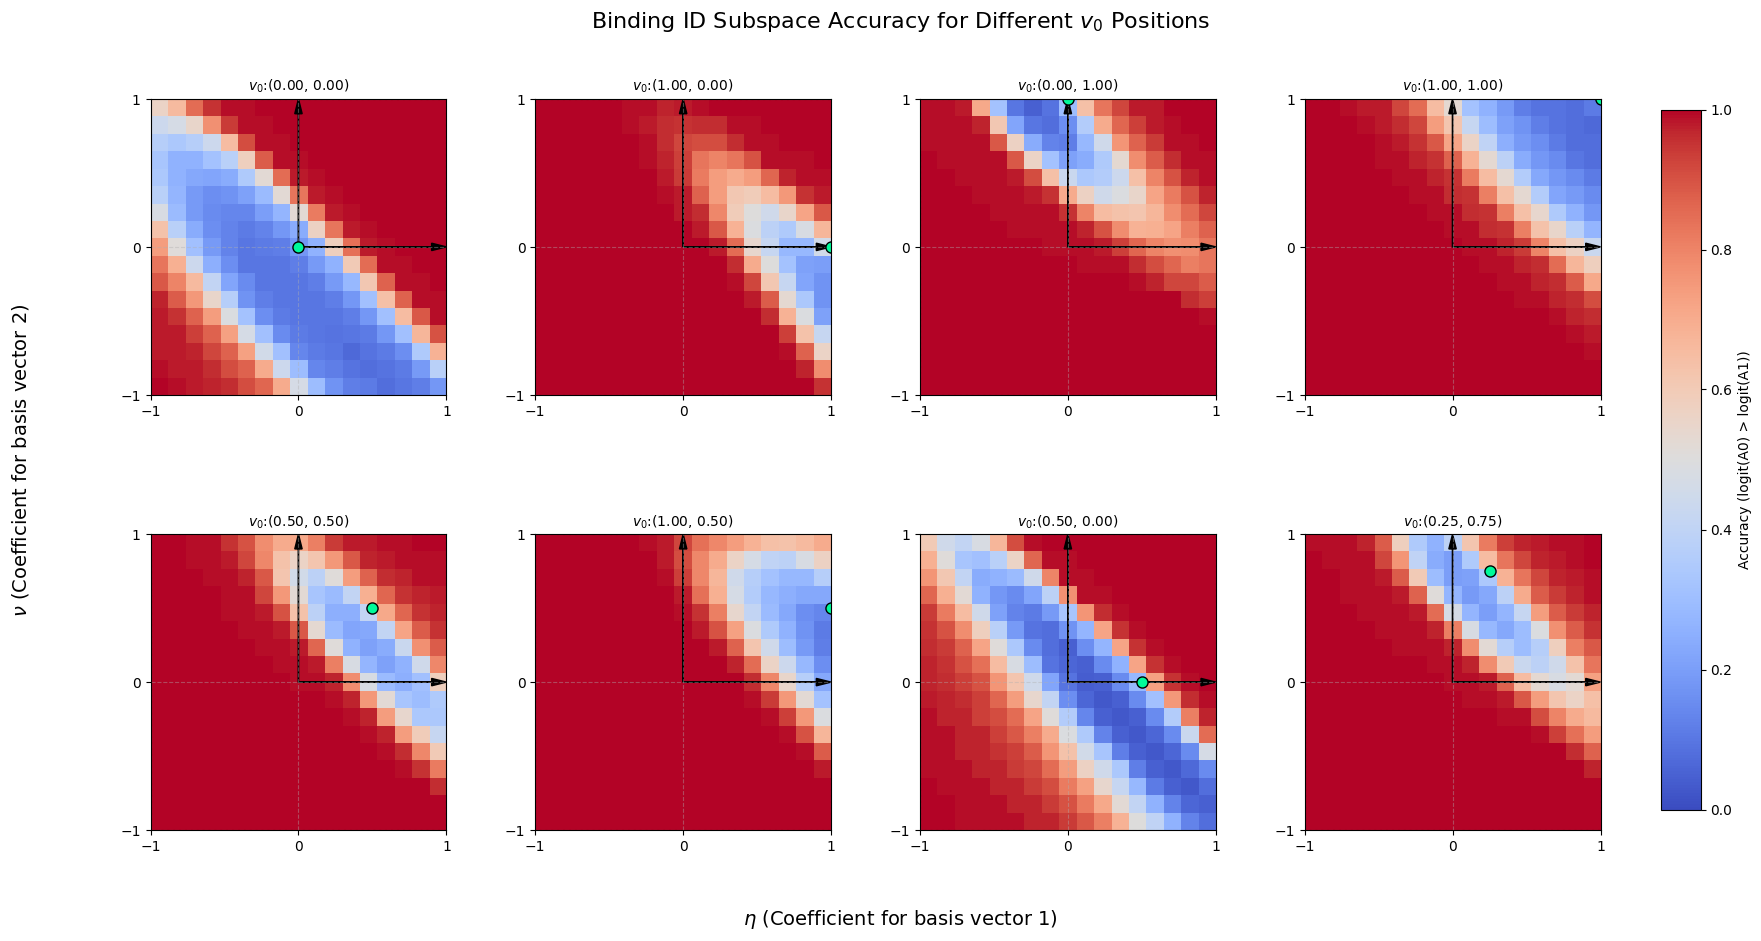


All 8 experiments and plots are complete.


In [ ]:
@torch.inference_mode()
def run_and_plot_on_ax(ax, eta0, nu0):
    """
    Runs the full geometry experiment for a single v0 position and draws on a given ax.
    """
    grid_range = np.arange(-1, 1.125, 0.125)
    accuracies = np.zeros((len(grid_range), len(grid_range)))

    v0_s = (eta0 * s_basis_vec1 + nu0 * s_basis_vec2)
    v0_c = (eta0 * c_basis_vec1 + nu0 * c_basis_vec2)

    answer0_tok_ids = torch.tensor([
        tokenizer(' ' + d['answers'][0]).input_ids[0] for d in test_data
    ], device=DEVICE)

    answer1_tok_ids = torch.tensor([
        tokenizer(' ' + d['answers'][1]).input_ids[0] for d in test_data
    ], device=DEVICE)

    print(f"Running experiment for v0 at ({eta0:.2f}, {nu0:.2f})...")

    for i, eta1 in enumerate(grid_range):
        for j, nu1 in enumerate(grid_range):
            v1_s = (eta1 * s_basis_vec1 + nu1 * s_basis_vec2)
            v1_c = (eta1 * c_basis_vec1 + nu1 * c_basis_vec2)

            fwd_hooks = []
            for l in range(N_LAYERS):
                hook_fn = partial(
                    geometry_intervention_hook_with_freezing,
                    orig_layer=orig_resid_pre[l], qpos=qpos,
                    p0_s=p0_s, p0_c=p0_c, p1_s=p1_s, p1_c=p1_c,
                    v0_s=v0_s[l], v0_c=v0_c[l], v1_s=v1_s[l], v1_c=v1_c[l],
                    erase_s=mean_vec_s[l], erase_c=mean_vec_c[l]
                )
                fwd_hooks.append((f"blocks.{l}.{RESID_HOOK}", hook_fn))

            patched_logits = model.run_with_hooks(
                test_batch["input_ids"].to(DEVICE),
                fwd_hooks=fwd_hooks,
                reset_hooks_end=True
            )

            final_token_logits = patched_logits[:, -1, :]
            batch_indices = torch.arange(len(test_data), device=DEVICE)
            logits_for_answer0 = final_token_logits[batch_indices, answer0_tok_ids]
            logits_for_answer1 = final_token_logits[batch_indices, answer1_tok_ids]
            correct_predictions = (logits_for_answer0 > logits_for_answer1).sum()
            acc = correct_predictions.item() / len(test_data)
            accuracies[j, i] = acc

    # --- PLOTTING on the provided ax ---
    im = ax.imshow(accuracies, origin='lower', cmap='coolwarm',
                   extent=[grid_range[0], grid_range[-1], grid_range[0], grid_range[-1]],
                   vmin=0.0, vmax=1.0)

    ax.plot(eta0, nu0, 'o', color='mediumspringgreen', markeredgecolor='black', markersize=8, label=f'$v_0$') # Smaller marker
    ax.arrow(0, 0, 1, 0, head_width=0.05, head_length=0.1, fc='k', ec='k', length_includes_head=True)
    ax.arrow(0, 0, 0, 1, head_width=0.05, head_length=0.1, fc='k', ec='k', length_includes_head=True)

    # Minimal labels for subplots
    ax.set_xticks([grid_range[0], 0, grid_range[-1]])
    ax.set_yticks([grid_range[0], 0, grid_range[-1]])
    ax.set_title(f"$v_0$:({eta0:.2f}, {nu0:.2f})", fontsize=10) # Smaller title
    ax.grid(True, linestyle='--', alpha=0.4)

    return im # Return the image artist for the colorbar


# --- MAIN SCRIPT ---
# Define the 8 positions for the fixed vector v0
v0_positions = [
    (0.0, 0.0), (1.0, 0.0), (0.0, 1.0), (1.0, 1.0),
    (0.5, 0.5), (1.0, 0.5), (0.5, 0.0), (0.25, 0.75)
]

# Create a 2x4 grid of subplots
fig, axes = plt.subplots(2, 4, figsize=(20, 10)) # Adjust figsize as needed
axes_flat = axes.flatten() # Flatten the 2D array of axes for easy iteration

# Loop through the positions and generate a plot for each on the corresponding subplot
for i, (eta0, nu0) in enumerate(v0_positions):
    if i < len(axes_flat): # Ensure we don't try to plot more than we have subplots
        im = run_and_plot_on_ax(axes_flat[i], eta0, nu0)

# Add a single colorbar for the entire figure
fig.subplots_adjust(right=0.85, hspace=0.3, wspace=0.3) # Adjust space for colorbar and titles
cbar_ax = fig.add_axes([0.88, 0.15, 0.02, 0.7]) # Position of the colorbar
fig.colorbar(im, cax=cbar_ax, label="Accuracy (logit(A0) > logit(A1))")

# Add common X and Y labels to the figure
fig.text(0.5, 0.04, "$\\eta$ (Coefficient for basis vector 1)", ha='center', va='center', fontsize=14)
fig.text(0.06, 0.5, "$\\nu$ (Coefficient for basis vector 2)", ha='center', va='center', rotation='vertical', fontsize=14)

fig.suptitle("Binding ID Subspace Accuracy for Different $v_0$ Positions", fontsize=16, y=0.95)

plt.show()

print("\nAll 8 experiments and plots are complete.")